In [ ]:
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/extensions')
sys.path
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [1]:
import csv
import pandas as pd
from read_data import read_csv_into_df

In [2]:
fields = ['Accession', 'Clinical history', 'Comment', 'Report text']
# dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')#
dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', 'rU') as csvfile:
    data1 = csv.reader(csvfile, delimiter=',')
    headers1 = data1.next()

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', 'rU') as csvfile:
    data2 = csv.reader(csvfile, delimiter=',')
    headers2 = data2.next()

# with open(dir + 'data/Reports/XKNEB_Jan_Jul_2017_anon.csv', 'rU') as csvfile:
#     data3 = csv.reader(csvfile, delimiter=',')
#     headers3 = data3.next()

cols1 = [headers1.index(item) for item in fields]
cols2 = [headers2.index(item) for item in fields]
# cols3 = [headers3.index(item) for item in fields]

In [3]:
df1 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', fields, cols1)
df2 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', fields, cols2)

In [4]:
df = pd.concat([df1,df2])
print df.count()

Accession           3576
Clinical history    2232
Comment             2402
Report text         3576
dtype: int64


In [5]:
# Check for missing information
df_nans = df[df.isnull().any(axis=1)]
df_nans.to_csv('missing_info.csv', sep=',')

In [6]:
df.to_csv('cleaned_reports.csv', sep=',')

In [7]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports = []
labels = []
words = []
for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report = [word for word in report_tok if word not in stopwords.words('english')]
    
    reports.append(filtered_report)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report]

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()

Vocab length:  1770
Avg no. of appearances:  51
STD:  387.271636453


Populating the interactive namespace from numpy and matplotlib
['.', 'knee', 'joint', 'xr', ',', 'medial', 'changes', 'degenerative', 'seen', 'space', 'right', 'patellofemoral', 'left', 'joints', 'change', 'compartment', 'previous', 'bilaterally', 'noted', 'loss', 'comparison', 'narrowing', 'spaces', 'compartments', 'tibiofemoral', 'mild', 'bilateral', 'osteophyte', 'imaging', 'bony', 'significant', 'moderate', 'osteophytosis', 'formation', 'within', 'lateral', 'made', 'knees', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'appearances', 'reduction', 'bone']


/Users/Aydan/anaconda/envs/PyTorch2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['char', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


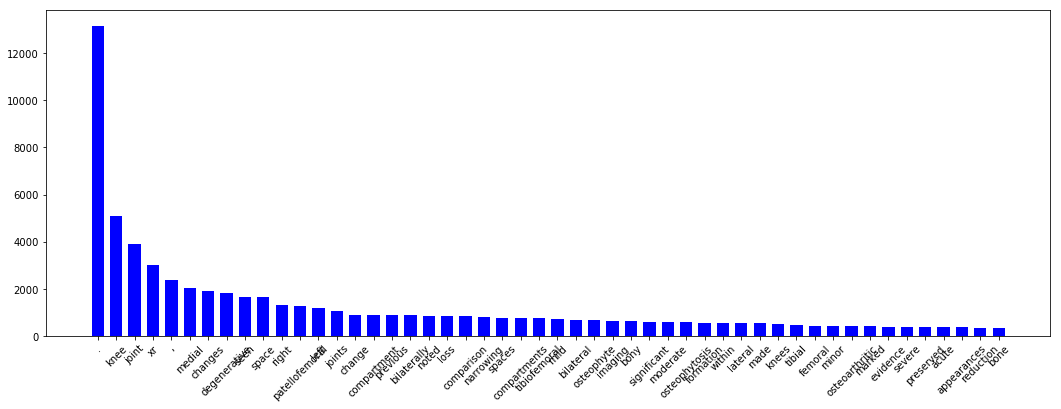

In [8]:
# Vocab stats
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

In [9]:
# Generate Doc2Vec embeddings for reports
import gensim
from gensim.models.doc2vec import LabeledSentence

class DocIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc, tags=[self.labels_list[idx]])
            
it = DocIterator(reports, labels)

In [10]:
# Train model
model = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model.build_vocab(it)
#training of model
for epoch in range(10):
    print 'iteration ' +str(epoch+1)
    model.train(it, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    model.train(it, total_examples=model.corpus_count, epochs=model.iter)
#saving the created model
model.save('doc2vec.model')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [11]:
# Test model
pd.options.display.max_colwidth = 4000
label_sample = random.choice(labels)
report_sample = df.loc[df['Accession'] == label_sample]['Report text']
print "Sample document: \n"
print report_sample.to_string()

most_similar = model.docvecs.most_similar(label_sample)
print "\nMost similar documents:"

for label, _ in most_similar:
    print (df.loc[df['Accession'] == label]['Report text']).to_string()
    print ''

Sample document: 

3015    XR Knee Both : Mild degenerative change seen in the patellofemoral joint space bilaterally with prominence of the tibial spines. Bilateral bipartite patella noted.

Most similar documents:
3154    XR Knee Both : Mild degenerative change is seen in the patellofemoral joint space bilaterally with prominence of the tibial spines.

1903    XR Knee Both : \nMild degenerative change is seen in the medial tibiofemoral joint compartment and patellofemoral joint space bilaterally.

2592    XR Knee Both : \n\nThere are mild bilateral degenerative changes.

2924    XR Knee Both : There is mild  degenerative change  in the patellofemoral joint space bilaterally. Appearances have not significantly progressed since the previous film of June 2011.

3339    XR Knee Both : \n\nThere is mild patellofemoral joint degenerative change bilaterally.  Otherwise normal bony appearances.

1647    XR Knee Both : \n\nMild bilateral degenerative changes are noted, most pronounced at the 

In [13]:
# Cluster documents using K-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def kmeans_clustering(vectors, num_clusters):
    # docvecs = model.docvecs
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(vectors)
    return kmeans.labels_
    
# Kmeans
num_clusters = 4
num_samples_kmeans = len(labels)

label_samples = random.choice(labels, num_samples_kmeans)
report_samples = []
vectors = []
for label in label_samples:
    report_samples.append(df.loc[df['Accession'] == label]['Report text'])
    vectors.append(model.docvecs[label])

# print report_samples_linebreaks[1]

kmeans_labels = kmeans_clustering(vectors, num_clusters)

<IPython.core.display.Javascript object>


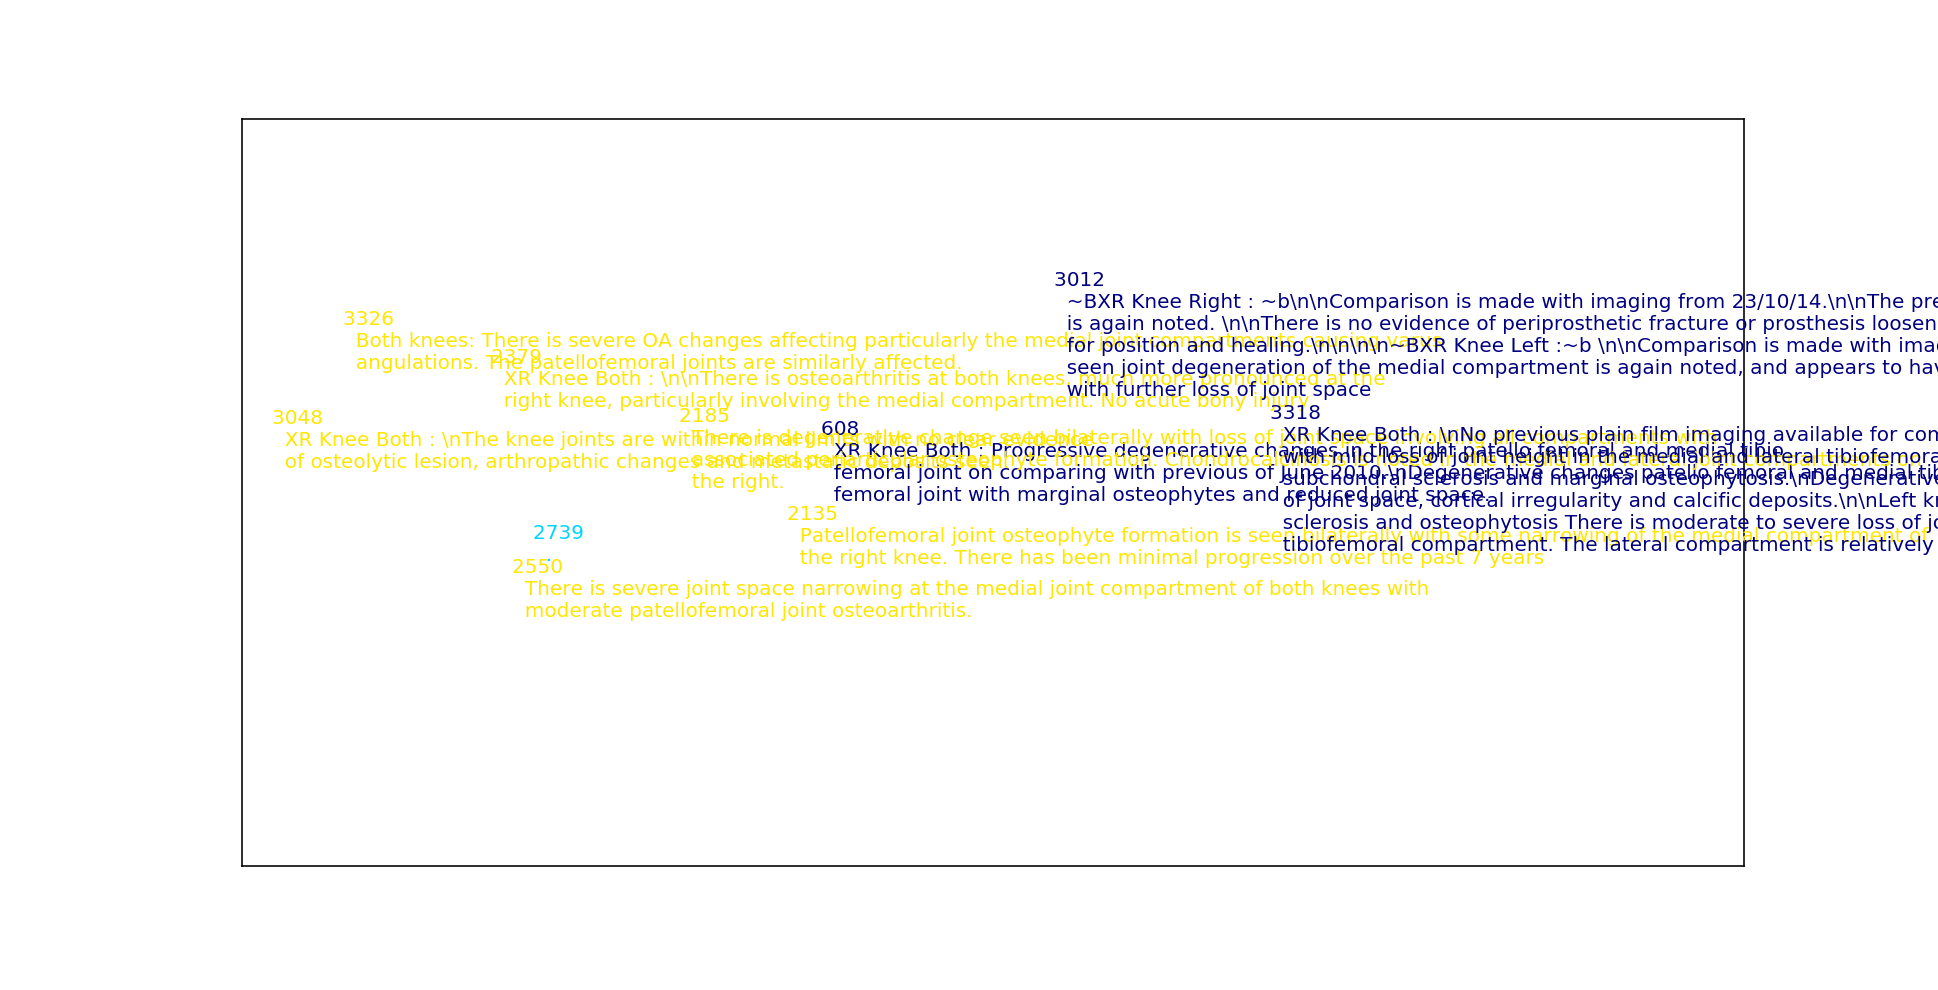

In [14]:
# Plot reports and clusters using PCA
#pylab.rcParams['figure.figsize'] = (18, 10)
%matplotlib notebook
%matplotlib notebook
def plot_pca(vectors, reports, kmeans_labels, num_clusters, num_samples):
    reports_tuple = np.array(zip(vectors, reports, kmeans_labels))
    reports_tuple[np.random.choice(len(reports_tuple),10)]
    ss_vectors = reports_tuple[:,0].tolist()
    ss_reports = reports_tuple[:,1].tolist()
    ss_kmeans_labels = reports_tuple[:,2].tolist()
    
    reduced_data = PCA(n_components=2).fit_transform(ss_vectors)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    #h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()

    plt.figure(1)
    plt.clf()

    colours = plt.cm.jet(np.linspace(0, 1, num_clusters))
    
    for i, x, y in zip(range(num_samples), reduced_data[:, 0], reduced_data[:, 1]):
        plt.annotate(ss_reports[i], xy=(x, y), xytext=(0, 0), textcoords='offset points', color=colours[ss_kmeans_labels[i]])
        #plt.scatter(x, y, color=colours[ss_kmeans_labels[i]], alpha=.8, lw=2, label=ss_reports[i])
                                        
    #plt.title('K-means Clustering of Knee X-ray Reports (reduced with PCA)\n')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# PCA
num_samples_pca = 10
report_samples_linebreaks = []
for report in report_samples:
    words = report.to_string().split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

plot_pca(vectors, report_samples_linebreaks, kmeans_labels, num_clusters, num_samples_pca)

Reports in cluster:  573
3213    XR Knee Both : Comparison has been made with previous of February 2006.\nProgressive degenerative disease with narrowing of the lateral tibiofemoral joint space and patellofemoral joint space. The tibial spine are spiky.
Name: Report text, dtype: object


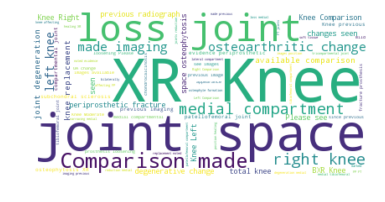

Reports in cluster:  1189
2177    ~BXR Knee Both : ~b\n\nThere is significant degenerative change seen involving all compartments, most pronounced involving the medial joint compartments bilaterally where there is significant loss of joint space and periarticular osteophyte formation.
Name: Report text, dtype: object


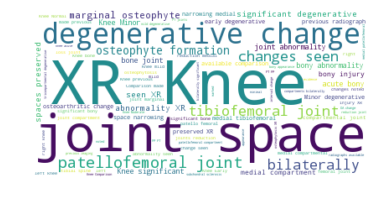

Reports in cluster:  1198
228    XR Knee Both : \nBilateral femorotibial joints reduction of medial compartmental joints spaces seen.
Name: Report text, dtype: object


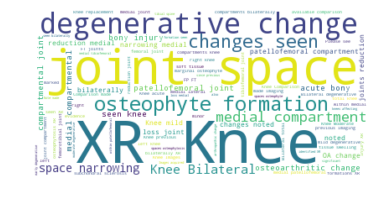

Reports in cluster:  616
203    XR Knee Both : Degenerative  changes patellofemoral and medial tibiofemoral joint in both knee joints with loss of joint space. Appearances have not changed from the previous of 26 May 2010.
Name: Report text, dtype: object


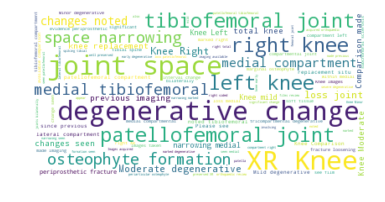

In [19]:
# Visualise words in clusters
from wordcloud import WordCloud
%matplotlib inline
clusters = {}
for k in range(num_clusters):
    wc = WordCloud(background_color="white")
    #report_sample =  random.sample(list(report_list))
    #print report_sample
    clusters["cluster{0}".format(k)] = [i for i,j in zip(report_samples, kmeans_labels) if j==k]
    #print random.choice(list(clusters["cluster{0}".format(k)]))
    print 'Reports in cluster: ', len(clusters["cluster{0}".format(k)])
    print clusters["cluster{0}".format(k)][np.random.choice(len(clusters["cluster{0}".format(k)]))]
    #print type(clusters["cluster{0}".format(k)])
    text_list = [' '.join(report) for report in clusters["cluster{0}".format(k)]]
    text = ' '.join(text_list)
    wordcloud = wc.generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.text(10,10, clusters["cluster{0}".format(k)][0])
    #plt.show()
    plt.show()

#print len(clusters['cluster0'])
